In [1]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['/home/rozenberszki/D_Project/wsnsl/configs/Scannet++/fe1733741f.yaml'])
#args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0.yaml'])

cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)
frame_reader = get_dataset(cfg, args, cfg["scale"], slam = slam)
frame_reader.__post_init__(slam)
zero_pos = frame_reader.poses[0]
zero_pos

INFO: The output folder is output/Scannet++/fe1733741f
INFO: The GT, generated and residual depth/color images can be found under output/Scannet++/fe1733741f/mapping_vis/
INFO: The mesh can be found under output/Scannet++/fe1733741f/mesh/
INFO: The checkpoint can be found under output/Scannet++/fe1733741f/ckpt/


tensor([[-0.8036,  0.0161, -0.5950,  9.7070],
        [-0.5933, -0.1019,  0.7985,  4.2147],
        [-0.0478,  0.9947,  0.0915,  1.6384],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [3]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis


class Segmenter(object):

    def __init__(self, slam, cfg, args, zero_pos, store_directory):
        self.smallestMaskSize = 1000
        if "smallestMaskSize" in cfg["Segmenter"]:
            self.smallestMaskSize = cfg["Segmenter"]["smallestMaskSize"]
        self.store_directory = store_directory
        self.zero_pos = zero_pos
        os.makedirs(f"{store_directory}", exist_ok=True)

        self.is_full_slam = cfg["Segmenter"]["full_slam"]
        self.store_vis = cfg["Segmenter"]["store_vis"]
        self.use_stored = cfg["Segmenter"]["use_stored"]
        self.samplePixelFarther=cfg["Segmenter"]["samplePixelFarther"]
        self.normalizePointNumber=cfg["Segmenter"]["normalizePointNumber"]
        self.first_min_area = cfg["mapping"]["first_min_area"]
        #TODO
        # self.
        """path_to_traj = cfg["data"]["input_folder"] + "/traj.txt"
        self.T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
        self.T_wc[:, 1:3] *= -1"""

        self.every_frame = cfg["mapping"]["every_frame"]
        # self.slam = slam
        # self.estimate_c2w_list = slam.estimate_c2w_list
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        self.estimate_c2w_list = slam.estimate_c2w_list
        s = np.ones((4, 4), int)
        if cfg["dataset"] == "tumrgbd":
            s[[0, 0, 1, 2], [0, 1, 2, 2]] *= -1
            print("tumrgbd")
        elif cfg["dataset"] == "replica":
            s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        elif cfg["dataset"] == "scannet++":
            s[[0, 0, 1, 1, 2,2], [1, 2, 0, 3, 0,3]] *= -1
            #s=1
        self.shift = s  # s"""
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        # self.idx_coarse_mapper = slam.idx_coarse_mapper

        self.every_frame_seg = cfg["Segmenter"]["every_frame"]
        self.points_per_instance = cfg["mapping"]["points_per_instance"]
        self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            cfg["cam"]["H"],
            cfg["cam"]["W"],
            cfg["cam"]["fx"],
            cfg["cam"]["fy"],
            cfg["cam"]["cx"],
            cfg["cam"]["cy"],
        )
        self.cfg = cfg
        self.update_cam()
        self.K = as_intrinsics_matrix([self.fx, self.fy, self.cx, self.cy])
        if args is None or args.input_folder is None:
            self.input_folder = cfg["data"]["input_folder"]
        else:
            self.input_folder = args.input_folder
        # self.color_paths = sorted(glob.glob(f"{self.input_folder}/results/frame*.jpg"))
        # self.depth_paths = sorted(glob.glob(f"{self.input_folder}/results/depth*.png"))
        self.frame_reader = get_dataset(
            cfg,
            args,
            cfg["scale"],
            device=cfg["mapping"]["device"],
            tracker=False,
            slam=slam,
        )
        self.n_img = self.frame_reader.n_img
        self.semantic_frames = slam.semantic_frames
        self.idx_segmenter = slam.idx_segmenter
        if not self.is_full_slam:
            self.idx = torch.tensor([self.n_img])
        else:
            self.idx = slam.idx  # Tracking index
            # Segmenter index
        # self.new_id = 0
        self.visualizer = vis.visualizerForIds()
        self.frame_numbers = []
        self.samples = None
        self.deleted = {}
    # TODO CHANGE THIS just for now rotated
        self.border = (
            cfg["Segmenter"]["border"]
            if cfg["Segmenter"]["border"]
            else "crop_edge" in cfg["cam"]
        )
        self.num_clusters = cfg["Segmenter"]["num_clusters"]
        self.overlap = cfg["Segmenter"]["overlap"]
        self.relevant = cfg["Segmenter"]["relevant"]
        self.max_id = 0
        self.update = {}
        self.verbose = cfg["Segmenter"]["verbose"]
        self.merging_parameter = cfg["Segmenter"]["merging_parameter"]
        self.hit_percent = cfg["Segmenter"]["hit_percent"]
        self.depthCondition = cfg["Segmenter"]["depthCondition"]

 
    def plot(self,idx):
        data = self.samples.copy()
        data = data[:, data[1] > -2]
        x = data[0]
        y = data[1]*-1
        z = data[2]*-1
        labels = data[3]

        # Create a scatter plot
        fig = plt.figure()
        fig.set_size_inches(10.5, 10.5)
        ax = fig.add_subplot(111, projection="3d")
        ax = fig.add_subplot(111, projection="3d")

        # Plot each point with a color corresponding to its label
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)
            ax.scatter(x[indices], y[indices], z[indices], s=3)

        # Set axis labels [-5,5],[-5,5],[-5,5]
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        # Add a legend
        ax.legend()
        plt.savefig("/home/rozenberszki/D_Project/wsnsl/Dataset/fe1733741f/test/3d/3Dplot_"+str(idx)+".png")
        plt.close()  # Close the plot to free up memory
        # Show the plot
    def update_cam(self):
        """
        Update the camera intrinsics according to pre-processing config,
        such as resize or edge crop.
        """
        # resize the input images to crop_size (variable name used in lietorch)
        if "crop_size" in self.cfg["cam"]:
            crop_size = self.cfg["cam"]["crop_size"]
            sx = crop_size[1] / self.W
            sy = crop_size[0] / self.H
            self.fx = sx * self.fx
            self.fy = sy * self.fy
            self.cx = sx * self.cx
            self.cy = sy * self.cy
            self.W = crop_size[1]
            self.H = crop_size[0]

        # croping will change H, W, cx, cy, so need to change here
        if self.cfg["cam"]["crop_edge"] > 0:
            self.H -= self.cfg["cam"]["crop_edge"] * 2
            self.W -= self.cfg["cam"]["crop_edge"] * 2
            self.cx -= self.cfg["cam"]["crop_edge"]
            self.cy -= self.cfg["cam"]["crop_edge"]

    def segment_reverse(self, idx):
        assert False
        img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        masksCreated, self.samples = id_generation.createReverseReverseMappingCombined(
            idx,
            self.T_wc,
            self.K,
            self.depth_paths,
            predictor=self.predictor,
            current_frame=img,
            samples=self.samples,
            num_of_clusters=4,
        )
        self.semantic_frames[idx // self.every_frame] = torch.from_numpy(masksCreated)

    def segment_idx(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        img = (img.cpu().numpy() * 255).astype(np.uint8)

        masksCreated, s, max_id, update = (
            id_generation.createReverseMappingCombined_area_sort(
                idx,
                self.estimate_c2w_list.cpu() * self.shift,
                self.K,
                depth.cpu(),
                predictor=self.predictor,
                max_id=self.max_id,
                update=self.update,
                points_per_instance=self.points_per_instance,
                current_frame=img,
                samples=self.samples,
                kernel_size=30,  # from 40*40 to 1000
                smallesMaskSize=self.smallestMaskSize,
                deleted=self.deleted,
                num_of_clusters=self.num_clusters,
                border=self.border,
                overlap_threshold=self.overlap,
                relevant_threshhold=self.relevant,
                every_frame=self.every_frame_seg,
                merging_parameter=self.merging_parameter,
                hit_percent=self.hit_percent,
            )
        )
        self.samples = s
        self.max_id = max_id
        frame = torch.from_numpy(masksCreated)
        self.semantic_frames[idx // self.every_frame_seg] = frame
        return frame

    def segment_idx_forAuto(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        img = (img.cpu().numpy() * 255).astype(np.uint8)
        '''print(len(self.estimate_c2w_list))
        print(self.border)
        print(self.estimate_c2w_list[0])
        print(self.estimate_c2w_list[1])'''

        masksCreated, s, max_id = id_generation.createFrontMappingAutosort(
            idx,
            self.estimate_c2w_list.cpu()* self.shift,
            self.K,
            depth.cpu(),
            self.predictor,
            max_id=self.max_id,
            current_frame=img,
            samples=self.samples,
            smallesMaskSize=self.smallestMaskSize,
            border=self.border,
            depthCondition=self.depthCondition,
            samplePixelFarther=self.samplePixelFarther,
            normalizePointNumber=self.normalizePointNumber,
           # verbose=True  
        )

        self.samples = s
        self.max_id = max_id

        frame = torch.from_numpy(masksCreated)
        adjusted_index = min(idx // self.every_frame_seg, len(self.semantic_frames) - 1)

        self.semantic_frames[adjusted_index] = frame
        return frame

    def predict_idx(self, idx):
        assert False
        img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        masksCreated = id_generation.createReverseMappingCombined_area_sort_predict(
            idx,
            self.T_wc,
            self.K,
            self.depth_paths,
            predictor=self.predictor,
            max_id=self.max_id,
            update=self.update,
            points_per_instance=self.points_per_instance,
            current_frame=img,
            samples=self.samples,
            kernel_size=40,
            every_frame=self.every_frame_seg,
            smallesMaskSize=40 * 40,
            deleted=self.deleted,
            num_of_clusters=self.num_clusters,
            border=self.border,
            overlap_threshold=self.overlap,
            relevant_threshhold=self.relevant,
        )

        self.semantic_frames[idx // self.every_frame] = torch.from_numpy(masksCreated)

    def segment_first(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()

        ids = id_generation.generateIds(masks, min_area=self.first_min_area)
        ids[depth.cpu() == 0] = -100
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max() + 1

        samplesFromCurrent = backproject.sample_from_instances_with_ids(
            ids, self.max_id, points_per_instance=100
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.zero_pos * self.shift,
            self.K,
            depth.cpu(),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        return realWorldSamples

    def segment_first_ForAuto(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam_forauto("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()

        ids = backproject.generateIds_Auto(
            masks, depth.cpu(), min_area=self.first_min_area, samplePixelFarther=self.samplePixelFarther,
        )
        if self.border != 0:
            ids[0 : 2 * self.border ] = -100
            ids[-2 * self.border  :] = -100
            ids[:, 0 : 2 * self.border ] = -100
            ids[:, -2 * self.border  :] = -100
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        #ids[depth.cpu() == 0] = -100
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max()
        visualizerForId = vis.visualizerForIds()  
        visualizerForId.visualizer(
            self.semantic_frames[0],
            path=f"/home/rozenberszki/D_Project/wsnsl/Dataset/fe1733741f/test/segmentations/0seg_{0}.png",
        )
        samplesFromCurrent = backproject.sample_from_instances_with_ids_area(
            ids=ids,
            normalizePointNumber=self.normalizePointNumber, 
        )
        # changed
        #self.zero_pos[:3,3]*=0.5
        #self.zero_pos*=self.shift
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.estimate_c2w_list.cpu()[0]* self.shift,
            self.K,
            depth.cpu(),
        )
        print("samplesFromCurrent: ", np.unique(samplesFromCurrent[2:, :]))
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        
        return realWorldSamples

    def process_keys(self, deleted):
        assert False
        for target in deleted.values():
            if target in deleted.keys():
                update_keys = [key for key, value in deleted.items() if value == target]
                for uk in update_keys:
                    deleted[uk] = deleted[target]
        return deleted

    def process_frames(self, semantic_frames):
        """process the semantic ids such that we have the minimum max_id number, eg, ids are 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,..,max_id"""
        ids = np.unique(semantic_frames)
        result = semantic_frames.clone()
        for i in range(len(ids)):
            result[semantic_frames == ids[i]] = i
        result[semantic_frames == -100] = -100
        semantic_frames[:, :, :] = result
        return len(ids) - 1

    def run(self, max=-1):
        if self.use_stored:
            index_frames = np.arange(0, self.n_img, self.every_frame_seg)
            for index in tqdm(index_frames, desc="Loading stored segmentations"):
                path = os.path.join(self.store_directory, f"seg_{index}.npy")
                self.semantic_frames[index // self.every_frame_seg] = torch.from_numpy(
                    np.load(path).astype(np.int32)
                )
            if self.n_img - 1 % self.every_frame_seg != 0:
                path = os.path.join(self.store_directory, f"seg_{self.n_img - 1}.npy")
                self.semantic_frames[-1] = torch.from_numpy(
                    np.load(path).astype(np.int32)
                )
            self.idx_segmenter[0] = self.n_img
            return self.semantic_frames, self.semantic_frames.max() + 1

        print("segment first frame")
        s = self.segment_first()
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        self.samples = s
        self.predictor = create_instance_seg.create_predictor("cuda")
        if max == -1:
            index_frames = np.arange(
                self.every_frame_seg, self.n_img, self.every_frame_seg
            )
            index_frames = np.concatenate((index_frames, [self.n_img - 1]))
            index_frames_predict = np.setdiff1d(
                np.arange(self.every_frame, self.n_img, self.every_frame), index_frames
            )
        else:
            index_frames = np.arange(self.every_frame_seg, max, self.every_frame_seg)
            index_frames_predict = np.setdiff1d(
                np.arange(self.every_frame, max, self.every_frame), index_frames
            )
        visualizerForId = vis.visualizerForIds()  # for testign
        for idx in tqdm(index_frames, desc="Segmenting frames"):

            # wait for tracker to estimate pose first
            while self.idx[0] < idx:
                # print("segmenter stuck")
                time.sleep(0.1)
            _ = self.segment_idx(idx)
            visualizerForId.visualize(
                self.semantic_frames[idx // self.every_frame_seg],
                path=f"{self.store_directory}/seg_{idx}.png",
            )
            if self.is_full_slam:
                self.idx_segmenter[0] = idx
            # self.plot()
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            while self.idx[0] < self.n_img - 1:
                # print("segmenter stuck")
                time.sleep(0.1)
            _ = self.segment_idx(self.n_img - 1)
            self.idx_segmenter[0] = self.n_img - 1

        if not self.is_full_slam:
            for old_instance in self.deleted.keys():
                self.semantic_frames[self.semantic_frames == old_instance] = (
                    self.deleted[old_instance]
                )
            self.max_id = self.process_frames(self.semantic_frames)
        # if self.verbose:
        # for i in range(len(self.semantic_frames)):Fself.estim
        make_gif_from_array(
            self.semantic_frames[index_frames // self.every_frame_seg],
            os.path.join(self.store_directory, "segmentation.gif"),
        )

        """for idx in tqdm(index_frames_predict, desc='Predicting frames'):
            print(f'predicting frame {idx}')
            self.predict_idx(idx)"""

        """reverse_index_frames = np.arange(self.n_img-1, -1, -self.every_frame)
        for idx in tqdm(reverse_index_frames, desc='Segmenting frames in reverse'):
            self.segment_reverse(idx)"""
        del self.predictor
        torch.cuda.empty_cache()

        # print('unprocessed map: ', self.deleted)
        # self.deleted = self.process_keys(self.deleted)
        # print('preocessed map: ', self.deleted)
        # if self.verbose:
        #    make_gif_from_array(self.semantic_frames, os.path.join(self.store_directory, f'segmentation_full.gif'))
        # print('unprocessed map: ', self.deleted)
        # self.deleted = self.process_keys(self.deleted)
        # print('preocessed map: ', self.deleted)
        # if self.verbose:
        #    make_gif_from_array(self.semantic_frames, os.path.join(self.store_directory, f'segmentation_full.gif'))

        visualizerForId = vis.visualizerForIds()
        # for i in range(len(self.semantic_frames)):
        """for i in range(len(self.semantic_frames)):
            visualizerForId.visualizer(self.semantic_frames[i])"""

        # store the segmentations, such that the dataset class (frame_reader) can read them
        for index in tqdm(
            [0] + list(index_frames),
            desc="Storing segmentations",
        ):
            path = os.path.join(self.store_directory, f"seg_{index}.npy")
            np.save(path, self.semantic_frames[index // self.every_frame_seg].numpy())
        if self.n_img - 1 % self.every_frame_seg != 0:
            path = os.path.join(self.store_directory, f"seg_{self.n_img - 1}.npy")
            np.save(path, self.semantic_frames[-1].numpy())
        if self.store_vis:
            for index in tqdm([0] + list(index_frames), desc="Storing visualizations"):
                path = os.path.join(self.store_directory, f"seg_{index}.png")
                self.visualizer.visualizer(
                    self.semantic_frames[index // self.every_frame_seg].numpy(),
                    path=path,
                )
        # EDIT THIS

        return self.semantic_frames, self.max_id

    def runAuto(self, max=-1):
        
        if self.use_stored:
            index_frames = np.arange(0, self.n_img, self.every_frame_seg)
            for index in tqdm(index_frames, desc="Loading stored segmentations"):
                path = os.path.join(self.store_directory, f"seg_{index}.npy")
                self.semantic_frames[index // self.every_frame_seg] = torch.from_numpy(
                    np.load(path).astype(np.int32)
                )
            if self.n_img - 1 % self.every_frame_seg != 0:
                path = os.path.join(self.store_directory, f"seg_{self.n_img - 1}.npy")
                self.semantic_frames[-1] = torch.from_numpy(
                    np.load(path).astype(np.int32)
                )
            self.idx_segmenter[0] = self.n_img
            return self.semantic_frames, self.semantic_frames.max() + 1

        visualizerForId = vis.visualizerForIds()
        #self.estimate_c2w_list[:,:3,3]*=0
        print("segment first frame")
        s = self.segment_first_ForAuto()
        visualizerForId.visualizer(
            self.semantic_frames[0],
            path=f"/home/rozenberszki/D_Project/wsnsl/Dataset/fe1733741f/test/segmentations/0seg_{0}.png",
        )
        print("finished segmenting first frame")
        if self.store_vis:
            visualizerForId = vis.visualizerForIds()
            visualizerForId.visualize(
                self.semantic_frames[0],
                path=f"{self.store_directory}/seg_{0}.png",
            )
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        self.samples = s
        self.predictor = create_instance_seg.create_sam_forauto("cuda")
        # create sam
        if max == -1:
            index_frames = np.arange(
                self.every_frame_seg, self.n_img, self.every_frame_seg
            )
        else:
            index_frames = np.arange(self.every_frame_seg, max, self.every_frame_seg)
            index_frames_predict = np.setdiff1d(
                np.arange(self.every_frame, max, self.every_frame), index_frames
            )
        for idx in tqdm(index_frames, desc="Segmenting frames"):
            '''while self.idx[0] < idx:
                # print("segmenter stuck")
                time.sleep(0.1)'''
            print("start segmenting frame: ", idx)
            Starttime=time.time()
            self.segment_idx_forAuto(idx)
            '''visualizerForId.visualizer(
                self.semantic_frames[idx],
                path=f"/home/rozenberszki/D_Project/wsnsl/Dataset/fe1733741f/test/segmentations/LastRUNseg_{self.semantic_frames[idx]}.png",
            )'''
            print(idx, "segmented")
            print(self.estimate_c2w_list.cpu()[idx])
            self.plot(idx)
            stopTime=time.time()
            print("time taken for segmenting frame: ", stopTime-Starttime)
            print("finished segmenting frame: ", idx)
            visualizerForId.visualize(
                self.semantic_frames[idx // self.every_frame_seg],
                path=f"{self.store_directory}/seg_{idx}.png",
            )
            if self.is_full_slam:
                self.idx_segmenter[0] = idx
            # self.plot()
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            '''while self.idx[0] < self.n_img - 1:
                # print("segmenter stuck")
                time.sleep(0.1)'''
            _ = self.segment_idx_forAuto(self.n_img - 1)
            self.idx_segmenter[0] = self.n_img - 1
            if self.store_vis:
                visualizerForId.visualize(
                    self.semantic_frames[-1],
                    path=f"{self.store_directory}/seg_{self.n_img - 1}.png",
                )

        
        del self.predictor
        torch.cuda.empty_cache()

        if not self.is_full_slam:
            self.max_id = self.process_frames(self.semantic_frames)

        if self.store_vis:
            index_frames = np.arange(0, self.n_img, self.every_frame_seg)
            if self.n_img - 1 % self.every_frame_seg != 0:
                index_frames = np.concatenate((index_frames, [self.n_img - 1]))
            make_gif_from_array(
                self.semantic_frames[index_frames // self.every_frame_seg],
                os.path.join(self.store_directory, "segmentation.gif"),
            )
            print(os.path.join(self.store_directory, "segmentation.gif"),)
        # store the segmentations, such that the dataset class (frame_reader) could load them
        # maybe the stored segmentations can be used for loading segmentations
        if False:
            for index in tqdm([0] + list(index_frames), desc="Storing segmentations"):
                path = os.path.join(self.store_directory, f"seg_{index}.npy")
                np.save(
                    path, self.semantic_frames[index // self.every_frame_seg].numpy()
                )

        if False:
            for index in tqdm([0] + list(index_frames), desc="Storing visualizations"):
                path = os.path.join(self.store_directory, f"seg_{index}.png")
                self.visualizer.visualize(
                    self.semantic_frames[index // self.every_frame_seg].numpy(),
                    path=path,
                )
        # EDIT THIS
        '''make_gif_from_array(
            self.semantic_frames[index_frames // self.every_frame_seg],
            os.path.join(self.store_directory, "segmentation.gif"),
        )'''
        return self.semantic_frames, self.max_id + 1


In [4]:
frame_reader.get_colorAndDepth(0)[1]

tensor([[1.3740, 1.3740, 1.3740,  ..., 3.4130, 3.2780, 3.2730],
        [1.3750, 1.3750, 1.3750,  ..., 3.4170, 3.2810, 3.2750],
        [1.3790, 1.3790, 1.3800,  ..., 3.4250, 3.2890, 3.2860],
        ...,
        [1.0910, 1.0930, 1.1020,  ..., 1.1610, 1.1520, 1.1500],
        [1.0930, 1.0960, 1.1070,  ..., 1.1530, 1.1460, 1.1440],
        [1.0940, 1.0980, 1.1080,  ..., 1.1500, 1.1440, 1.1420]],
       device='cuda:0')

In [5]:
segmenter = Segmenter(slam, cfg, args, zero_pos, 'test')

In [6]:
segmenter.estimate_c2w_list = np.concatenate([p[None] for p in segmenter.frame_reader.poses], axis=0)
segmenter.estimate_c2w_list=torch.tensor( segmenter.estimate_c2w_list)

In [7]:
import os
import shutil

folder_path = '/home/rozenberszki/D_Project/wsnsl/Dataset/fe1733741f/test'


segment first frame
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22]
samplesFromCurrent:  [ 0  1  2  3  4  5  7  8  9 10 12 13 14 15]
finished segmenting first frame


Segmenting frames:   0%|          | 0/28 [00:00<?, ?it/s]

start segmenting frame:  1
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21]
unique ids [-100    0    1    2    3    4    5    7    8    9   12   13   14   15
   16]
1 segmented
tensor([[-0.8035,  0.0177, -0.5950,  9.7115],
        [-0.5935, -0.1019,  0.7984,  4.2136],
        [-0.0465,  0.9946,  0.0924,  1.6371],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:   4%|▎         | 1/28 [00:01<00:36,  1.35s/it]

time taken for segmenting frame:  1.279611349105835
finished segmenting frame:  1
start segmenting frame:  2
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22]
unique ids [-100    0    1    2    3    4    5    7    8    9   12   13   14   15
   17]
2 segmented
tensor([[-0.8056,  0.0211, -0.5920,  9.7200],
        [-0.5911, -0.0953,  0.8010,  4.2144],
        [-0.0396,  0.9952,  0.0892,  1.6393],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:   7%|▋         | 2/28 [00:02<00:36,  1.41s/it]

time taken for segmenting frame:  1.365752935409546
finished segmenting frame:  2
start segmenting frame:  3
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23]


No handles with labels found to put in legend.


unique ids [-100    1    2    3    4    5    9   10   12   15   18   19   20   21
   22   23]
3 segmented
tensor([[-0.8144,  0.0226, -0.5799,  9.7362],
        [-0.5793, -0.0913,  0.8100,  4.2139],
        [-0.0346,  0.9956,  0.0874,  1.6420],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  11%|█         | 3/28 [00:04<00:37,  1.49s/it]

time taken for segmenting frame:  1.5222077369689941
finished segmenting frame:  3
start segmenting frame:  4
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19]
unique ids [-100    1    2    3    4    5    9   12   14   18   19   23   24]


No handles with labels found to put in legend.


4 segmented
tensor([[-0.8226,  0.0354, -0.5675,  9.7663],
        [-0.5676, -0.1112,  0.8158,  4.2104],
        [-0.0343,  0.9932,  0.1116,  1.6413],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  14%|█▍        | 4/28 [00:06<00:38,  1.60s/it]

time taken for segmenting frame:  1.6464097499847412
finished segmenting frame:  4
start segmenting frame:  5
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21]


No handles with labels found to put in legend.


unique ids [-100    1    3    4    5    8    9   14   18   25   26   27   28   29]
5 segmented
tensor([[-0.8497,  0.0733, -0.5221,  9.8188],
        [-0.5252, -0.2035,  0.8263,  4.1922],
        [-0.0457,  0.9763,  0.2114,  1.6154],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  18%|█▊        | 5/28 [00:08<00:38,  1.69s/it]

time taken for segmenting frame:  1.7794008255004883
finished segmenting frame:  5
start segmenting frame:  6
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22]
unique ids [-100    0    1    3    4    5    8    9   14   18   30   31   32   33
   34]


No handles with labels found to put in legend.


6 segmented
tensor([[-0.8815,  0.1214, -0.4563,  9.8784],
        [-0.4709, -0.2983,  0.8302,  4.1580],
        [-0.0354,  0.9467,  0.3201,  1.5707],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  21%|██▏       | 6/28 [00:09<00:38,  1.77s/it]

time taken for segmenting frame:  1.8525371551513672
finished segmenting frame:  6
start segmenting frame:  7
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22]
unique ids [-100    0    1    3    4    5    8    9   18   27   30   35]


No handles with labels found to put in legend.


7 segmented
tensor([[-0.9039,  0.1625, -0.3956,  9.9427],
        [-0.4275, -0.3718,  0.8240,  4.1071],
        [-0.0132,  0.9140,  0.4055,  1.5192],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  25%|██▌       | 7/28 [00:11<00:38,  1.82s/it]

time taken for segmenting frame:  1.8397505283355713
finished segmenting frame:  7
start segmenting frame:  8
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19]
unique ids [-100    0    1    3    4    5    9   14   18   20   30   31   36   37]


No handles with labels found to put in legend.


8 segmented
tensor([[-9.2056e-01,  1.8182e-01, -3.4570e-01,  1.0015e+01],
        [-3.9048e-01, -4.5035e-01,  8.0294e-01,  4.0331e+00],
        [-9.6981e-03,  8.7414e-01,  4.8557e-01,  1.4649e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


Segmenting frames:  29%|██▊       | 8/28 [00:13<00:36,  1.85s/it]

time taken for segmenting frame:  1.8333821296691895
finished segmenting frame:  8
start segmenting frame:  9
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15]
unique ids [-100    0    4    5    9   14   18   20   30   31   38]


No handles with labels found to put in legend.


9 segmented
tensor([[-0.9422,  0.1745, -0.2861, 10.1013],
        [-0.3348, -0.5266,  0.7814,  3.9364],
        [-0.0143,  0.8320,  0.5546,  1.4269],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  32%|███▏      | 9/28 [00:15<00:35,  1.85s/it]

time taken for segmenting frame:  1.8028416633605957
finished segmenting frame:  9
start segmenting frame:  10
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20]
unique ids [-100    0    5    8    9   14   18   30   31   39   40   41]


No handles with labels found to put in legend.


10 segmented
tensor([[-0.9616,  0.1428, -0.2343, 10.1759],
        [-0.2739, -0.5499,  0.7890,  3.8377],
        [-0.0162,  0.8229,  0.5679,  1.4267],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  36%|███▌      | 10/28 [00:17<00:34,  1.89s/it]

time taken for segmenting frame:  1.8819241523742676
finished segmenting frame:  10
start segmenting frame:  11
zg_filtered []
zg_filtered []
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18]
unique ids [-100    0    1    5    7    8    9   27   30   33   39   42   43]
11 segmented
tensor([[-0.9794,  0.1193, -0.1627, 10.2501],
        [-0.2014, -0.5327,  0.8220,  3.7570],
        [ 0.0114,  0.8379,  0.5458,  1.4377],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:  39%|███▉      | 11/28 [00:19<00:32,  1.93s/it]

time taken for segmenting frame:  1.9417119026184082
finished segmenting frame:  11
start segmenting frame:  12
zg_filtered [-10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23]
unique ids [-100    0    5    8    9   14   16   18   30   31   44  

No handles with labels found to put in legend.


12 segmented
tensor([[-9.9750e-01,  4.0950e-02, -5.7588e-02,  1.0336e+01],
        [-7.0547e-02, -5.3053e-01,  8.4472e-01,  3.6715e+00],
        [ 4.0394e-03,  8.4667e-01,  5.3210e-01,  1.4360e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


Segmenting frames:  43%|████▎     | 12/28 [00:21<00:31,  1.96s/it]

time taken for segmenting frame:  1.9584693908691406
finished segmenting frame:  12
start segmenting frame:  13
zg_filtered [-10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -1

No handles with labels found to put in legend.


13 segmented
tensor([[-0.9958, -0.0683,  0.0612, 10.4175],
        [ 0.0885, -0.5414,  0.8361,  3.5812],
        [-0.0240,  0.8380,  0.5452,  1.4363],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  46%|████▋     | 13/28 [00:23<00:30,  2.00s/it]

time taken for segmenting frame:  2.044764280319214
finished segmenting frame:  13
start segmenting frame:  14
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26]
unique ids [-100    3    5    7    8    9   18   30   33   44   53   54   55   56
   57   58   59   60   61]


No handles with labels found to put in legend.


14 segmented
tensor([[-0.9671, -0.1539,  0.2027, 10.4624],
        [ 0.2539, -0.5292,  0.8096,  3.4889],
        [-0.0173,  0.8344,  0.5508,  1.4488],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  50%|█████     | 14/28 [00:25<00:28,  2.07s/it]

time taken for segmenting frame:  2.141390085220337
finished segmenting frame:  14
start segmenting frame:  15
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30]
unique ids [-100    8    9   14   30   33   37   44   53   56   62   63   64   65
   66   67]
15 segmented
tensor([[-0.9191, -0.2314,  0.3188, 10.4748],
        [ 0.3935, -0.4996,  0.7717,  3.3885],
        [-0.0193,  0.8348,  0.5503,  1.4467],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:  54%|█████▎    | 15/28 [00:28<00:27,  2.08s/it]

time taken for segmenting frame:  2.0589771270751953
finished segmenting frame:  15
start segmenting frame:  16
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29]
unique ids [-100    1    8    9   14   20   30   33   44   53   56   68   69   70
   71   72   73   74   75]


No handles with labels found to put in legend.


16 segmented
tensor([[-0.8755, -0.2784,  0.3949, 10.4738],
        [ 0.4824, -0.4588,  0.7462,  3.2758],
        [-0.0265,  0.8438,  0.5360,  1.4522],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  57%|█████▋    | 16/28 [00:30<00:25,  2.13s/it]

time taken for segmenting frame:  2.1524271965026855
finished segmenting frame:  16
start segmenting frame:  17
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35]
unique ids [-100    5    7    8    9   14   20   30   33   36   44   53   56   70
   76   77   78   79   80   81   82   83   84]


No handles with labels found to put in legend.


17 segmented
tensor([[-0.8378, -0.2930,  0.4606, 10.4749],
        [ 0.5456, -0.4206,  0.7249,  3.1620],
        [-0.0187,  0.8586,  0.5123,  1.4763],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  61%|██████    | 17/28 [00:32<00:24,  2.25s/it]

time taken for segmenting frame:  2.4879815578460693
finished segmenting frame:  17
start segmenting frame:  18
zg_filtered [-10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000.]
zg_filtered [-10000. -1

/home/rozenberszki/anaconda3/envs/wsnsl/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


18 segmented
tensor([[-0.8159, -0.2904,  0.5000, 10.4880],
        [ 0.5776, -0.3674,  0.7290,  3.0641],
        [-0.0280,  0.8835,  0.4675,  1.5235],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  64%|██████▍   | 18/28 [00:35<00:23,  2.30s/it]

time taken for segmenting frame:  2.3523638248443604
finished segmenting frame:  18
start segmenting frame:  19
zg_filtered [-10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.
 -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000. -10000.


/home/rozenberszki/D_Project/wsnsl/src/utils/vis.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))
No handles with labels found to put in legend.


19 segmented
tensor([[-0.7813, -0.2763,  0.5596, 10.5072],
        [ 0.6229, -0.2891,  0.7269,  2.9610],
        [-0.0391,  0.9166,  0.3980,  1.5527],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  68%|██████▊   | 19/28 [00:37<00:21,  2.41s/it]

time taken for segmenting frame:  2.5947961807250977
finished segmenting frame:  19
start segmenting frame:  20
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38   39   40
   41   42   43]
unique ids [-100    2    5    7    9   12   16   50   68   71   87  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124]


No handles with labels found to put in legend.


20 segmented
tensor([[-0.7625, -0.2641,  0.5907, 10.5505],
        [ 0.6419, -0.1937,  0.7420,  2.8393],
        [-0.0816,  0.9449,  0.3172,  1.5853],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  71%|███████▏  | 20/28 [00:40<00:20,  2.53s/it]

time taken for segmenting frame:  2.729617118835449
finished segmenting frame:  20
start segmenting frame:  21
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38   39]
unique ids [-100    5    7    9   14   36   68   71   87  121  125  126  127  128
  129  130  131  132  133  134  135  136  137]


No handles with labels found to put in legend.


21 segmented
tensor([[-0.7504, -0.2912,  0.5933, 10.6090],
        [ 0.6474, -0.1429,  0.7487,  2.7046],
        [-0.1332,  0.9459,  0.2957,  1.6172],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  75%|███████▌  | 21/28 [00:43<00:18,  2.61s/it]

time taken for segmenting frame:  2.744084358215332
finished segmenting frame:  21
start segmenting frame:  22
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38]
unique ids [-100    5    7    9   14   71   81   84   87  138  139  140  141  142
  143  144  145  146  147  148  149  150  151]
22 segmented
tensor([[-0.7747, -0.2978,  0.5579, 10.6552],
        [ 0.6172, -0.1639,  0.7695,  2.5751],
        [-0.1377,  0.9404,  0.3108,  1.6264],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:  79%|███████▊  | 22/28 [00:46<00:16,  2.75s/it]

time taken for segmenting frame:  2.9979045391082764
finished segmenting frame:  22
start segmenting frame:  23
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35]
unique ids [-100    0    1    5    9   14   18   68   78   81   87  152  153  154
  155  156  157  158  159  160  161  162  163]
23 segmented
tensor([[-0.7918, -0.2874,  0.5389, 10.6927],
        [ 0.6030, -0.2279,  0.7645,  2.4337],
        [-0.0969,  0.9303,  0.3538,  1.6092],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:  82%|████████▏ | 23/28 [00:49<00:14,  2.89s/it]

time taken for segmenting frame:  3.1533234119415283
finished segmenting frame:  23
start segmenting frame:  24
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33]
unique ids [-100    0    1    4    5    9   14   71   81   84   87  117  155  156
  157  164  165  166  167  168]


No handles with labels found to put in legend.


24 segmented
tensor([[-0.7923, -0.3147,  0.5228, 10.7027],
        [ 0.6024, -0.2676,  0.7520,  2.2739],
        [-0.0967,  0.9107,  0.4015,  1.5704],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Segmenting frames:  86%|████████▌ | 24/28 [00:53<00:12,  3.01s/it]

time taken for segmenting frame:  3.226699113845825
finished segmenting frame:  24
start segmenting frame:  25
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30]
unique ids [-100    0    1    2    5    9   14   71   81   87  169  170  171  172
  173  174  175  176]
25 segmented
tensor([[-0.7749, -0.3963,  0.4924, 10.7048],
        [ 0.6180, -0.3117,  0.7217,  2.0949],
        [-0.1326,  0.8636,  0.4864,  1.5397],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:  89%|████████▉ | 25/28 [00:56<00:09,  3.21s/it]

time taken for segmenting frame:  3.5994701385498047
finished segmenting frame:  25
start segmenting frame:  26
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32]
unique ids [-100    0    1    2    5    9   14   71   81   84   87  104  119  177
  178  179  180  181]
26 segmented
tensor([[-0.7680, -0.4269,  0.4774, 10.7344],
        [ 0.6306, -0.3743,  0.6798,  1.9399],
        [-0.1115,  0.8232,  0.5567,  1.5166],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:  93%|█████████▎| 26/28 [01:00<00:06,  3.43s/it]

time taken for segmenting frame:  3.856778144836426
finished segmenting frame:  26
start segmenting frame:  27
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28]
unique ids [-100    0    1    5    9   14   71   87  104  117  171  182  183  184
  185  186  187  188]
27 segmented
tensor([[-0.7750, -0.4500,  0.4437, 10.7572],
        [ 0.6230, -0.4262,  0.6559,  1.8065],
        [-0.1061,  0.7848,  0.6106,  1.4766],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:  96%|█████████▋| 27/28 [01:04<00:03,  3.62s/it]

time taken for segmenting frame:  3.991208791732788
finished segmenting frame:  27
start segmenting frame:  28
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
zg_filtered [-10000. -10000. -10000. ... -10000. -10000. -10000.]
[-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24]
unique ids [-100    1    5   71   81   87  171  183  189  190  191  192  193  194
  195  196]
28 segmented
tensor([[-0.7660, -0.4328,  0.4753, 10.7894],
        [ 0.6412, -0.4617,  0.6130,  1.6705],
        [-0.0459,  0.7743,  0.6312,  1.4186],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


No handles with labels found to put in legend.
Segmenting frames:  96%|█████████▋| 27/28 [01:08<00:02,  2.55s/it]

time taken for segmenting frame:  4.092101335525513
finished segmenting frame:  28


IndexError: index 28 is out of bounds for dimension 0 with size 28

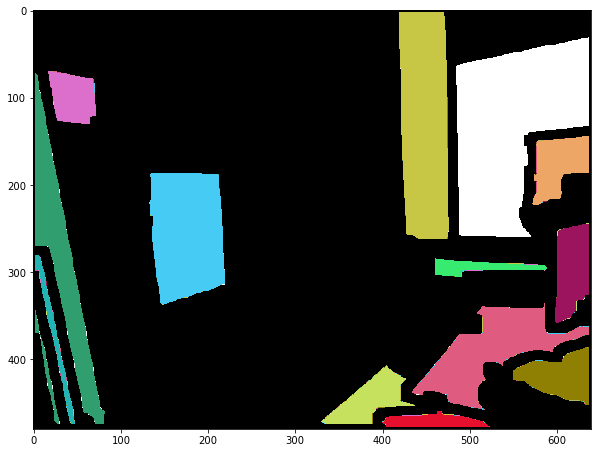

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

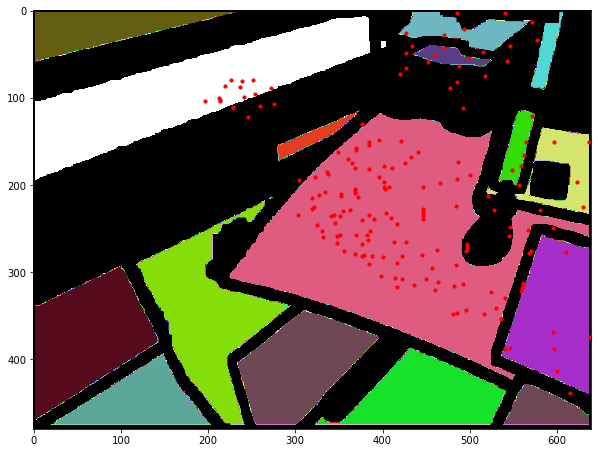

In [8]:
segmenter.runAuto()

In [ ]:
import numpy as np
import open3d as o3d
points = np.random.rand(10,3)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 2: Compute a mesh using the Ball Pivoting algorithm
# You may need to adjust the radii parameter based on the scale of your point cloud
radii = [0.005, 0.01, 0.02, 0.04]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       pcd, o3d.utility.DoubleVector(radii))

# Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

In [ ]:
frame_reader.n_img//50

48

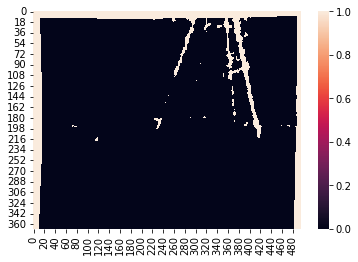

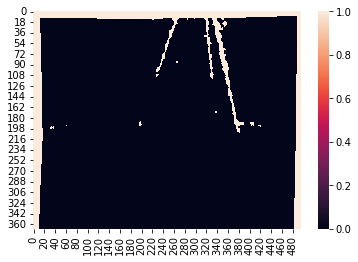

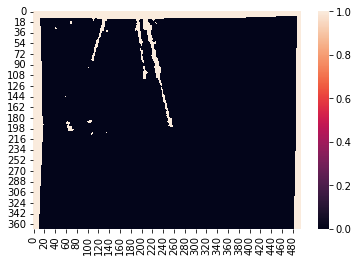

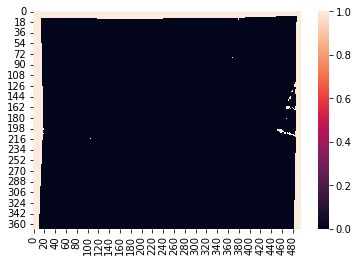

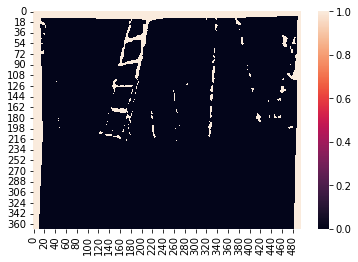

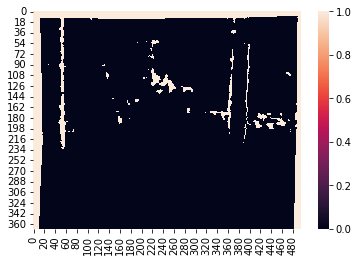

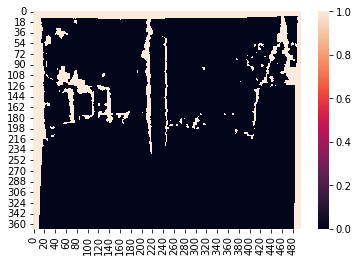

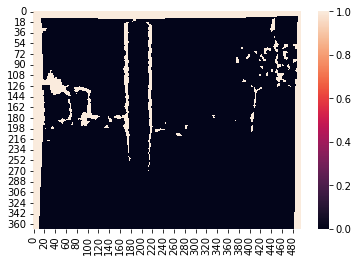

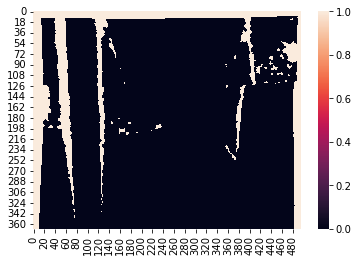

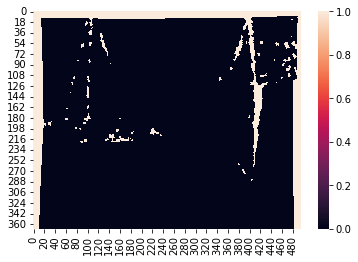

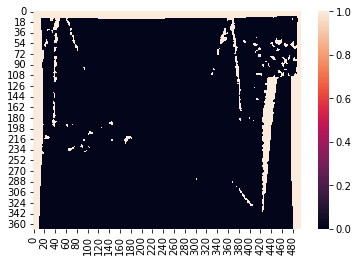

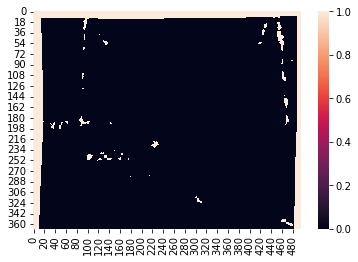

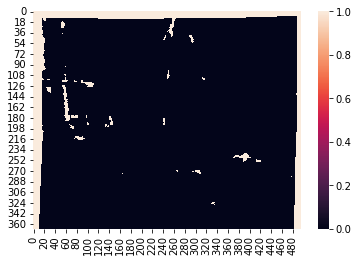

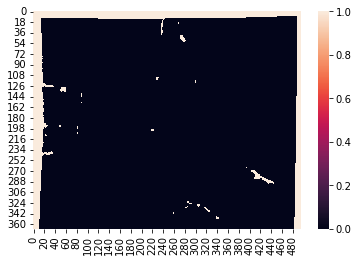

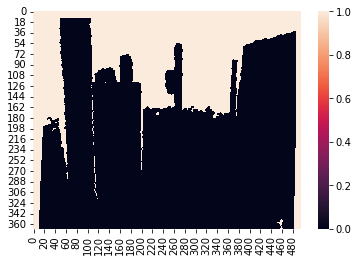

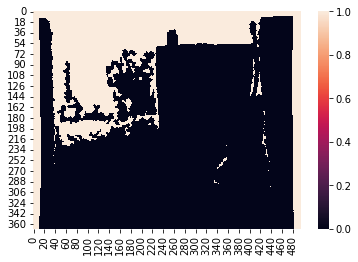

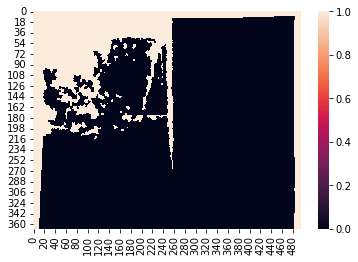

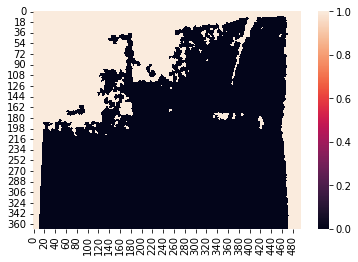

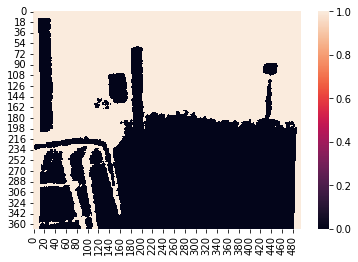

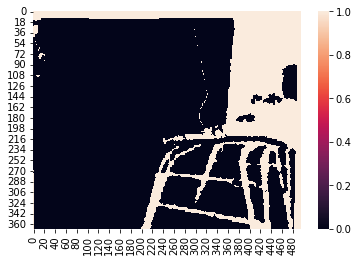

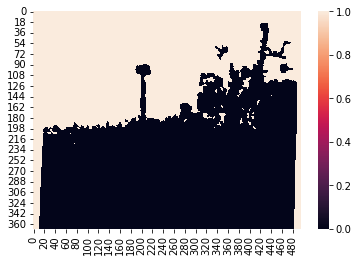

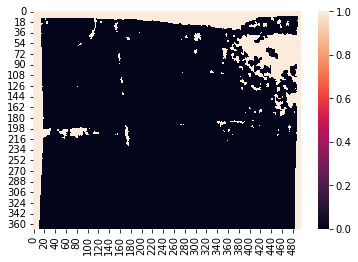

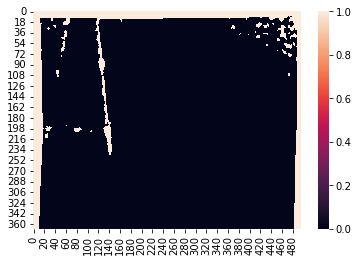

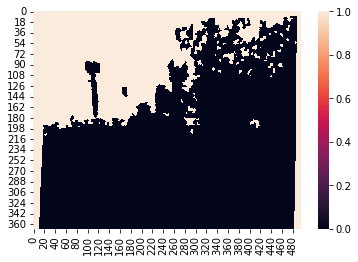

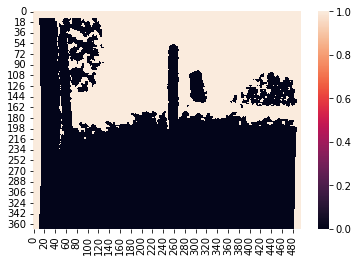

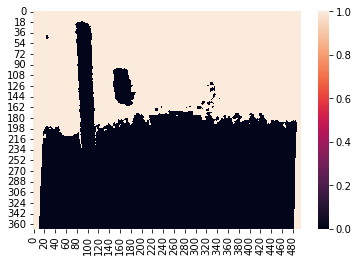

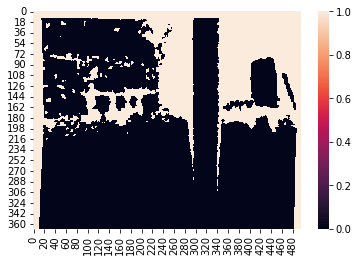

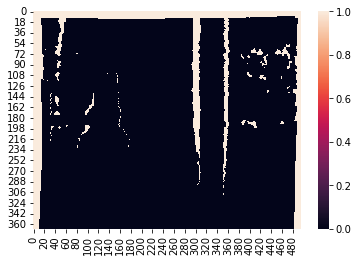

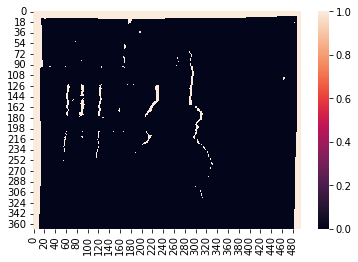

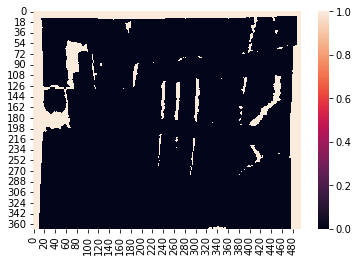

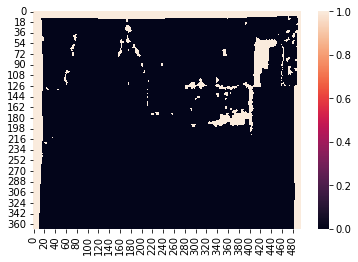

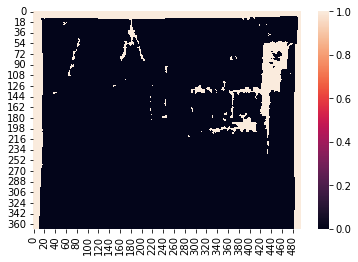

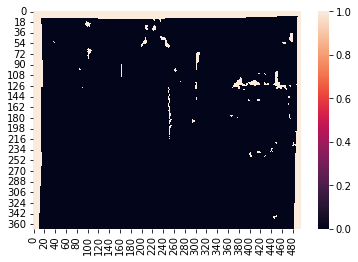

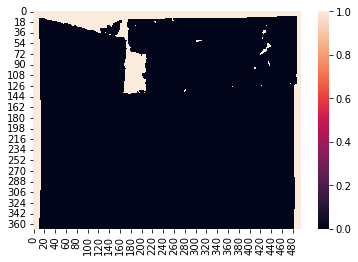

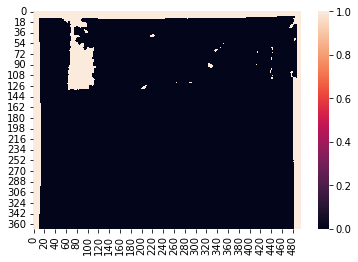

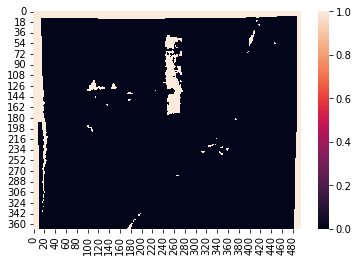

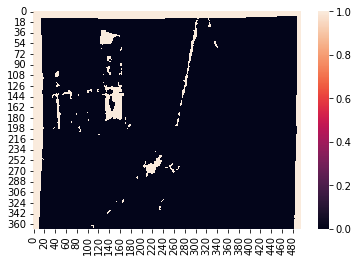

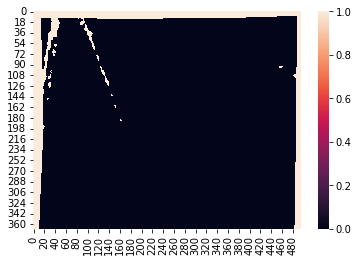

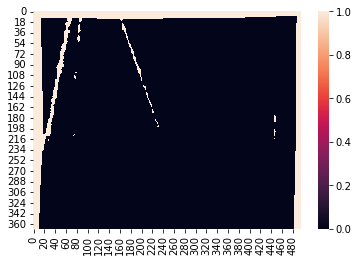

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
for idx in range(0, frame_reader.n_img, 50):
    _,_, depth,_,_ = frame_reader[idx]
    sns.heatmap(depth.cpu().numpy() == 0)
    plt.show()
    plt.clf()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


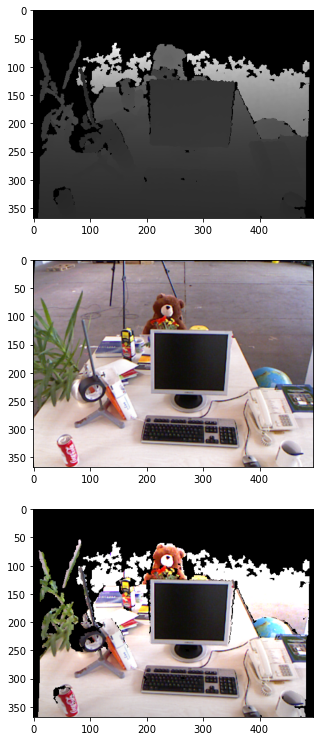

In [ ]:
color, depth= frame_reader.get_colorAndDepth(1000)
#_,depth = frame_reader.get_colorAndDepth(80)
color = color.cpu().numpy()
depth = depth.cpu().numpy()
depth = depth / np.max(depth)
depth = np.stack([depth, depth, depth], axis=-1)
fig, ax = plt.subplots(3, 1, figsize=(40, 13))
ax[0].imshow(depth)
#plt.show()
ax[1].imshow(color)
#plt.show()
ax[2].imshow(color*depth*5)